In [1]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt
import xlrd
import tensorflow.keras.backend as K
import pandas as pd
import requests
# import nvidia_smi

from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.python.client import device_lib



from tensorflow.python.ops import confusion_matrix
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops

# Changing directories to access the dataset
d = os.getcwd()
if d != '/home/ec2-user/SageMaker/Semantic_Segmentation' :
    os.chdir("..")
from labels import *

(512, 512, 3)


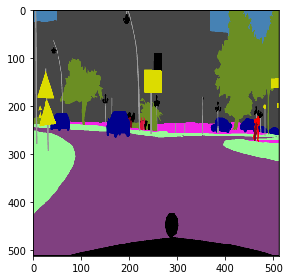

In [2]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png')
train = np.asarray(Image.open(BytesIO(response.content)).convert('RGB'), dtype='uint8')
train = cv2.resize(train, (512,512), interpolation = cv2.INTER_AREA)
# train = cv2.cvtColor(train, cv2.COLOR_BGR2RGB)
print(train.shape)
imshow(train)
plt.show()

(512, 512, 3)


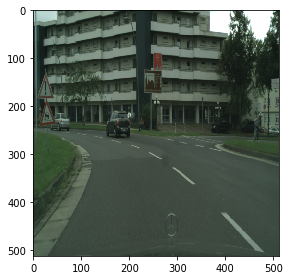

In [3]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/train/aachen/aachen_000000_000019_leftImg8bit.png')
train1 = np.asarray(Image.open(BytesIO(response.content)).convert('RGB'), dtype='uint8')
train1 = cv2.resize(train1, (512,512), interpolation = cv2.INTER_AREA)
# train = cv2.cvtColor(train, cv2.COLOR_BGR2RGB)
print(train1.shape)
imshow(train1)
plt.show()

In [4]:
labelID = {}
rgbColorID = {}

for i,label in enumerate(labels):
    labelID[i] = label.name
    rgbColorID[i] = label.color

print(labelID)
print(rgbColorID)

{0: 'unlabeled', 1: 'dynamic', 2: 'ground', 3: 'road', 4: 'sidewalk', 5: 'parking', 6: 'rail track', 7: 'building', 8: 'wall', 9: 'fence', 10: 'guard rail', 11: 'bridge', 12: 'tunnel', 13: 'pole', 14: 'traffic light', 15: 'traffic sign', 16: 'vegetation', 17: 'terrain', 18: 'sky', 19: 'person', 20: 'rider', 21: 'car', 22: 'truck', 23: 'bus', 24: 'caravan', 25: 'trailer', 26: 'train', 27: 'motorcycle', 28: 'bicycle'}
{0: (0, 0, 0), 1: (111, 74, 0), 2: (81, 0, 81), 3: (128, 64, 128), 4: (244, 35, 232), 5: (250, 170, 160), 6: (230, 150, 140), 7: (70, 70, 70), 8: (102, 102, 156), 9: (190, 153, 153), 10: (180, 165, 180), 11: (150, 100, 100), 12: (150, 120, 90), 13: (153, 153, 153), 14: (250, 170, 30), 15: (220, 220, 0), 16: (107, 142, 35), 17: (152, 251, 152), 18: (70, 130, 180), 19: (220, 20, 60), 20: (255, 0, 0), 21: (0, 0, 142), 22: (0, 0, 70), 23: (0, 60, 100), 24: (0, 0, 90), 25: (0, 0, 110), 26: (0, 80, 100), 27: (0, 0, 230), 28: (119, 11, 32)}


In [5]:
def rgb_to_onehot(rgb_image, colormap):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    index = 0
    for i, cls in enumerate(colormap):
        encoded_image[:,:,index] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        index += 1
        
    return encoded_image

In [6]:
trainingImagesNames = np.load('TrainNames.npz')['image']
trainingImagesNames = list(trainingImagesNames)
trainingMasksNames = np.load('TrainNames.npz')['label']
trainingMasksNames = list(trainingMasksNames)
validationImagesNames = np.load('ValNames.npz')['image']
validationImagesNames = list(validationImagesNames)
validationMasksNames = np.load('ValNames.npz')['label']
validationMasksNames = list(validationMasksNames)

for i in range(len(trainingImagesNames)):
    trainingImagesNames[i] = 'https://test-seg.s3.amazonaws.com/Cityscrapes/' + trainingImagesNames[i]
    trainingMasksNames[i] = 'https://test-seg.s3.amazonaws.com/Cityscrapes/gtFine/' + trainingMasksNames[i]

for i in range(len(validationImagesNames)):
    validationImagesNames[i] = 'https://test-seg.s3.amazonaws.com/Cityscrapes/' + validationImagesNames[i]
    validationMasksNames[i] = 'https://test-seg.s3.amazonaws.com/Cityscrapes/gtFine/' + validationMasksNames[i]

print(trainingImagesNames[0])
print(trainingMasksNames[0])
print(validationImagesNames[0])
print(validationMasksNames[0])

https://test-seg.s3.amazonaws.com/Cityscrapes/train/aachen/aachen_000000_000019_leftImg8bit.png
https://test-seg.s3.amazonaws.com/Cityscrapes/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png
https://test-seg.s3.amazonaws.com/Cityscrapes/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png
https://test-seg.s3.amazonaws.com/Cityscrapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png


In [7]:
# Input Image Dimensions
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
numClasses = 29
batchSize = 1
learningRate = 0.001
stepsPerEpoch = len(trainingImagesNames[0:20])//batchSize
numOfEpoch = 100
validationSteps = len(validationImagesNames[0:10])//batchSize

In [8]:
class My_Generator(tf.keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X_train = []
        Y_train = []
        
        for image in batch_x:
            response = requests.get(image)
            train = np.asarray(Image.open(BytesIO(response.content)))
            train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            X_train.append(train)

        for image in batch_y:
            response = requests.get(image)
            img1 = np.asarray(Image.open(BytesIO(response.content)).convert('RGB'))
#             imgCopy = np.zeros(img1.shape, dtype = 'uint8')
#             for i,cls in enumerate(rgbColorID):
#                 if i in otherClassIndices:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[0]
#                 else:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[i]
            Mask = cv2.resize(img1, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            Mask = rgb_to_onehot(Mask, rgbColorID)
            Y_train.append(Mask)
            
        return (np.array(X_train, dtype='uint8'), np.array(Y_train, dtype='uint8'))

In [9]:
# Building the U-net model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # Defining the input layer
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # Converting input pixels to floating values

c1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1) # To prevent neural net from over fitting
c1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2) # To prevent neural net from over fitting
c2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3) # To prevent neural net from over fitting
c3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4) # To prevent neural net from over fitting
c4 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5) # To prevent neural net from over fitting
c5 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
# p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

# c6 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(p5)
# c6 = tf.keras.layers.Dropout(0.3)(c6) # To prevent neural net from over fitting
# # c6 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(c6)
# # p6 = tf.keras.layers.MaxPooling2D((2,2))(c6)

# Decoding the layers
u7 = tf.keras.layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
# h, w = u7.shape[1:3].as_list()
# cr5 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c4)
u7 = tf.keras.layers.concatenate([u7, c4])
c7 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7) # To prevent neural net from over fitting
c7 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)

u8 = tf.keras.layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c7)
# h, w = u8.shape[1:3].as_list()
# cr4 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c3)
u8 = tf.keras.layers.concatenate([u8, c3])
c8 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8) # To prevent neural net from over fitting
c8 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)

u9 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c8)
# h, w = u9.shape[1:3].as_list()
# cr3 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c2)
u9 = tf.keras.layers.concatenate([u9, c2])
c9 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9) # To prevent neural net from over fitting
c9 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)

u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c9)
# h, w = u10.shape[1:3].as_list()
# cr2 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c1)
u10 = tf.keras.layers.concatenate([u10, c1], axis=3)
c10 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10) # To prevent neural net from over fitting
c10 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)

outputs = tf.keras.layers.Conv2D(numClasses, (1,1), activation='softmax', padding='same')(c10)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=numClasses),'accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
# # Model Checkpoint
# checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

# callbacks = [
#              tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#              tf.keras.callbacks.TensorBoard(log_dir='logs')]

# Model Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_multiclass.h5',
                                                  verbose=2,
                                                  save_best_only=True,
                                                  monitor='mean_io_u',
                                                  mode='max')

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=1,
                                              monitor='mean_io_u',
                                              mode='max'),
             tf.keras.callbacks.TensorBoard(log_dir='logs',
                                            write_graph=True)]

In [11]:
trainingDataGenerator = My_Generator(trainingImagesNames[0:20], trainingMasksNames[0:20], 1)
validationDataGenerator = My_Generator(validationImagesNames[0:10], validationMasksNames[0:10], 1)


results = model.fit(trainingDataGenerator,
                              validation_data=validationDataGenerator,
                              steps_per_epoch=stepsPerEpoch,
                              epochs=numOfEpoch,
                              validation_steps= validationSteps,
#                               use_multiprocessing=True,
                              max_queue_size=batchSize,
                              verbose=1,
                              callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 10 steps
Epoch 1/100
 1/20 [>.............................] - ETA: 5:58WARNING:tensorflow:Early stopping conditioned on metric `mean_io_u` which is not available. Available metrics are: 


KeyboardInterrupt: 

In [ ]:
X_test = []
Y_test = []

for i in range(5):
    response = requests.get(trainingImagesNames[i])
    train = np.asarray(Image.open(BytesIO(response.content)))
    train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
    X_test.append(train)

for i in range(5):
    response = requests.get(trainingMasksNames[i])
    train = np.asarray(Image.open(BytesIO(response.content)).convert('RGB'))
    train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
    Y_test.append(train)
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
preds_val = model.predict(X_test, verbose=1)

In [ ]:
def onehot_to_rgb(onehot, colormap):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [ ]:
preds_valRGB = []
for i in range(len(X_test)):
    preds_valRGB.append(onehot_to_rgb(preds_val[i], rgbColorID))

In [ ]:
for i in range(29):
    imshow(preds_val[0][:,:,i])
    plt.show()

In [ ]:
# Comparing the results

ix = random.randint(0, len(preds_valRGB))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Validation Image')
ax1.grid(False)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(preds_valRGB[ix])
ax3.grid(False)